In [47]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
# generate data
n = 10
sigma = 5
data = pd.DataFrame(columns=['x', 'y'])
data['x'] = np.linspace(0, 8, n)
k = 3.4
c = 23
data['y'] = k*data['x'] + c + np.random.randn(n)*sigma
# plot data
plt.scatter(data['x'], data['y'])

In [48]:
# form combinations of parameters and define their priors
from itertools import product

# create parameter space for slope and intercept
resolution = 200
data_slope = np.linspace(-10, 10, num=resolution)
data_inter = np.linspace(-50, 50, num=resolution)

# create dataframe for parameters
df = pd.DataFrame(columns=['slope','intercept','prior'])
# parameter combinations
comb =list(product(data_slope, data_inter))
temp = pd.DataFrame(data=comb, columns=['slope','intercept'])

df['slope'] = temp['slope']
df['intercept'] = temp['intercept']
slope_prior = norm(1, 5).pdf(df['slope'])
intercept_prior = norm(20, 5).pdf(df['intercept'])
df['prior'] = slope_prior*intercept_prior
df.head()


,slope,intercept,prior
0,-10.0,-50.000000,1.556067e-46
1,-10.0,-49.497487,6.322699e-46
2,-10.0,-48.994975,2.543256e-45
3,-10.0,-48.492462,1.012724e-44
4,-10.0,-47.989950,3.992134e-44


In [49]:
# form temporary table for parameters and data
# temp indexes for full join
data['temp'] = 1
df['temp'] = 1

# save old indexes before join
df['org_idx'] = df.index
# full join
df = pd.merge(df, data, on=['temp'])
df.head()

,slope,intercept,prior,temp,org_idx,x,y
0,-10.0,-50.0,1.556067e-46,1,0,0.000000,20.614038
1,-10.0,-50.0,1.556067e-46,1,0,0.888889,30.403693
2,-10.0,-50.0,1.556067e-46,1,0,1.777778,38.756268
3,-10.0,-50.0,1.556067e-46,1,0,2.666667,31.259425
4,-10.0,-50.0,1.556067e-46,1,0,3.555556,27.912643


In [50]:
# calculate likelihoods

df['residual'] = df['y'] - (df['slope'] * df['x'] + df['intercept'])
df['likelihood'] = norm(0, sigma).pdf(df['residual'])

# group by slope and intercept (=org_idx) to get product of likelihoods per parameters
df = df.groupby(['org_idx'], as_index=False).agg({'slope': 'first', 'intercept': 'first', 'prior': 'first', 'likelihood': 'prod'})

df.head()

,org_idx,slope,intercept,prior,likelihood
0,0,-10.0,-50.000000,1.556067e-46,0.0
1,1,-10.0,-49.497487,6.322699e-46,0.0
2,2,-10.0,-48.994975,2.543256e-45,0.0
3,3,-10.0,-48.492462,1.012724e-44,0.0
4,4,-10.0,-47.989950,3.992134e-44,0.0


In [51]:
# calculate posterior
df['posterior'] = df['prior'] * df['likelihood']
# normalize
df['posterior'] = df['posterior'] / df['posterior'].sum()
df.head()

,org_idx,slope,intercept,prior,likelihood,posterior
0,0,-10.0,-50.000000,1.556067e-46,0.0,0.0
1,1,-10.0,-49.497487,6.322699e-46,0.0,0.0
2,2,-10.0,-48.994975,2.543256e-45,0.0,0.0
3,3,-10.0,-48.492462,1.012724e-44,0.0,0.0
4,4,-10.0,-47.989950,3.992134e-44,0.0,0.0


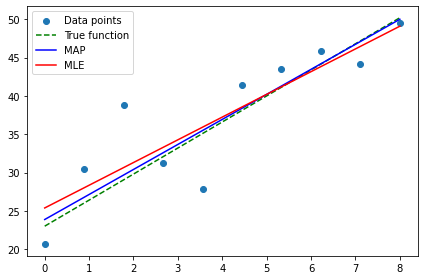

In [80]:
# plot data points
plt.scatter(data['x'], data['y'])
plt.plot(data['x'], 3.4*data['x']+23, 'g--')
# plot bayes
idx = df['posterior'].argmax()
k = df['slope'][idx]
c = df['intercept'][idx]
plt.plot(data['x'], data['x']*k + c, 'b')
# plot max likelihood
idx = df['likelihood'].argmax()
k = df['slope'][idx]
c = df['intercept'][idx]

plt.plot(data['x'], data['x']*k + c, 'r')
plt.legend(['Data points', 'True function', 'MAP', 'MLE'])


Text(0, 0.5, 'Intercept')

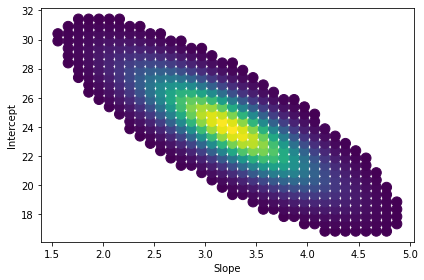

In [75]:
#X, Y = np.meshgrid(df['slope'], df['intercept'])
%matplotlib inline
x, y = np.array(df['slope']), np.array(df['intercept'])
z = np.array(df['posterior'])

idx = np.argwhere(z > 0.0001)
x, y, z = x[idx], y[idx], z[idx]

plt.scatter(x, y, c=z, s=100)
plt.xlabel('Slope')
plt.ylabel('Intercept')
